In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import copy
import warnings
import scipy
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import matplotlib
import cm_xml_to_matplotlib as make_cmap

import celeri

plt.rcParams["text.usetex"] = False


In [3]:
# Constants and parameters
N_GRID_X = 100
N_GRID_Y = 100
N_CONTOUR_LEVELS = 12
MAKE_EIGENVECTOR_EXAMPLE_PLOT = False
EIGENVECTOR_SWEEP_EXPERIMENT = True
SMOOTHING_SWEEP_EXPERIMENT = True

cmap = make_cmap.make_cmap("w_ymiddle1.xml")
# cmap = cmap.reversed()

In [4]:
def inpolygon(xq, yq, xv, yv):
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = matplotlib.path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)


def rbf_interpolate(fill_value):
    # Observation coordinates and data
    x_vec = np.linspace(231, 239, N_GRID_X)
    y_vec = np.linspace(38, 52, N_GRID_Y)
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    y_mat = y_mat
    centroids_lon = meshes[0].centroids[:, 0]
    centroids_lat = meshes[0].centroids[:, 1]
    centroids_val = fill_value

    # Package for RBFInterpolator
    xgrid = np.stack((x_mat, y_mat))
    xflat = xgrid.reshape(2, -1).T
    xobs = np.vstack((centroids_lon, centroids_lat)).T
    yobs = centroids_val
    yflat = scipy.interpolate.RBFInterpolator(
        xobs, yobs, kernel="cubic", smoothing=0.01, epsilon=1.5
    )(xflat)
    ygrid = yflat.reshape(N_GRID_X, N_GRID_Y)
    return xgrid, ygrid


def get_synthetic_displacements(mesh, tri_linear_operator):
    """
    Prescribe dip-slip in a Gaussian pattern
    """
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - np.mean(mesh.centroids[:, 0])
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - np.mean(mesh.centroids[:, 1])

    # Hardcoded northern Cascadia example that Jack suggested.
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - 234.5
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - 48.5

    # Southern Cascadia example
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - np.mean(mesh.centroids[:, 0]) - 2
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - np.mean(mesh.centroids[:, 1])

    tri_centroid_to_mesh_centroid_distance = np.sqrt(
        tri_centroid_to_mesh_lon**2 + tri_centroid_to_mesh_lat**2
    )
    dip_slip_distribution = np.exp(
        -((tri_centroid_to_mesh_centroid_distance / 1.0) ** 2.0)
    )
    slip_distribution = np.zeros(2 * dip_slip_distribution.size)
    slip_distribution[1::2] = dip_slip_distribution  # Dip slip only
    slip_distribution[0::2] = 1e-4 * np.random.randn(
        dip_slip_distribution.size
    )  # Adding a teeny amount of non-zero noise here just so contouring works...ugh
    synthetic_displacements = tri_linear_operator @ slip_distribution
    return slip_distribution, synthetic_displacements


def plot_slip_distributions(
    slip_distribution_input, slip_distribution_estimated, suptitle_string
):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.title("input strike-slip")
    interpolate_and_plot(slip_distribution_input[0::2])

    plt.subplot(1, 4, 2)
    plt.title("estimated strike-slip")
    interpolate_and_plot(slip_distribution_estimated[0::2])

    plt.subplot(1, 4, 3)
    plt.title("input dip-slip")
    interpolate_and_plot(slip_distribution_input[1::2])

    plt.subplot(1, 4, 4)
    plt.title("estimated dip-slip")
    interpolate_and_plot(slip_distribution_estimated[1::2])

    plt.suptitle(suptitle_string)
    plt.show()


def interpolate_and_plot(fill_value):
    # Interpolate values onto a regular grid for plotting
    xgrid, ygrid = rbf_interpolate(fill_value)
    xflat = xgrid.reshape(2, -1).T
    inpolygon_vals = inpolygon(
        xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
    )
    inpolygon_vals = np.reshape(inpolygon_vals, (N_GRID_X, N_GRID_Y))
    ygrid[~inpolygon_vals] = np.nan

    # Plot
    levels = np.linspace(-1.0, 1.0, N_CONTOUR_LEVELS)
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore", message="No contour levels were found within the data range."
        )
        plt.contourf(*xgrid, ygrid, cmap=cmap, levels=levels, extend="both")
        plt.contour(
            *xgrid,
            ygrid,
            colors="k",
            linestyles="solid",
            linewidths=0.25,
            levels=levels,
        )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xticks([])
    plt.yticks([])


def get_eigenvalues_and_eigenvectors(n_eigenvalues, x, y, z):
    n_tde = x.size

    # Calculate Cartesian distances between triangle centroids
    centroid_coordinates = np.array([x, y, z]).T
    distance_matrix = scipy.spatial.distance.cdist(
        centroid_coordinates, centroid_coordinates, "euclidean"
    )

    # Rescale distance matrix to the range 0-1
    distance_matrix = (distance_matrix - np.min(distance_matrix)) / np.ptp(
        distance_matrix
    )

    # Calculate correlation matrix
    correlation_matrix = np.exp(-distance_matrix)

    # https://stackoverflow.com/questions/12167654/fastest-way-to-compute-k-largest-eigenvalues-and-corresponding-eigenvectors-with
    eigenvalues, eigenvectors = scipy.linalg.eigh(
        correlation_matrix,
        subset_by_index=[n_tde - n_eigenvalues, n_tde - 1],
    )
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)
    ordered_index = np.flip(np.argsort(eigenvalues))
    eigenvalues = eigenvalues[ordered_index]
    eigenvectors = eigenvectors[:, ordered_index]
    return eigenvalues, eigenvectors


def make_eigenvector_example_plot():
    n_eigenvalues = 110
    eigenvalues, eigenvectors = get_eigenvalues_and_eigenvectors(
        n_eigenvalues, meshes[0].x_centroid, meshes[0].y_centroid, meshes[0].z_centroid
    )

    # Plot select eigenmodes
    plt.figure(figsize=(16, 13))

    for i in range(0, 18):
        ax = plt.subplot(3, 6, i + 1)

        # Shift eigenmodes by plotting row to show some dynamic range
        if i > 5 and i <= 11:
            i = i - 6 + 30
        elif i > 11:
            i = i - 12 + 100
        fill_value = fill_value = eigenvectors[:, i]

        # Normalize fill_value for interpretable plotting
        min_value = np.min(fill_value)
        max_value = np.max(fill_value)
        if np.abs(max_value) > np.abs(min_value):
            fill_value = fill_value / max_value
        else:
            fill_value = fill_value / np.abs(min_value)

        if i == 0 and np.nanmean(fill_value) < 0:
            fill_value = -1 * fill_value

        interpolate_and_plot(fill_value)
        plt.title(f"mode {i}")

    plt.savefig("eigenvector_examples.pdf")
    plt.savefig("eigenvector_examples.png", dpi=500)
    plt.show()


def get_synthetic_displacements_test(mesh, sources, tde_matrix, observation_noise):
    n_vels = tde_matrix.shape[0]
    slip_distribution = np.zeros(2 * mesh.n_tde)
    strike_slip_distribution = np.zeros(mesh.n_tde)
    dip_slip_distribution = np.zeros(mesh.n_tde)

    for i in range(sources.lon.size):
        source_to_mesh_centroid_lon = mesh.centroids[:, 0] - sources.lon[i]
        source_to_mesh_centroid_lat = mesh.centroids[:, 1] - sources.lat[i]

        source_to_mesh_centroid_distance = np.sqrt(
            source_to_mesh_centroid_lon**2.0 + source_to_mesh_centroid_lat**2.0
        )

        # Guassian slip pattern
        if sources.slip_type[i] == "strike_slip":
            strike_slip_distribution += sources.magnitude[i] * np.exp(
                -((source_to_mesh_centroid_distance / 1.0) ** 2.0)
            )
        elif sources.slip_type[i] == "dip_slip":
            dip_slip_distribution += sources.magnitude[i] * np.exp(
                -((source_to_mesh_centroid_distance / 1.0) ** 2.0)
            )

    slip_distribution[0::2] = strike_slip_distribution  # Strike slip only
    slip_distribution[1::2] = dip_slip_distribution  # Dip slip only

    # Adding a teeny amount of non-zero noise here just so contouring works
    # TODO: Move this to plotting routine
    slip_distribution[0::2] += 1e-4 * np.random.randn(mesh.n_tde)
    slip_distribution[1::2] += 1e-4 * np.random.randn(mesh.n_tde)

    # Forward calculation of synthetic displacments
    synthetic_displacements = tde_matrix @ slip_distribution

    # Add noise to synthetic displacments
    synthetic_displacements += observation_noise * np.random.randn(n_vels)

    return slip_distribution, synthetic_displacements


In [5]:
COMMAND_FILE_NAME = "../data/command/western_north_america_command.json"
command = celeri.get_command(COMMAND_FILE_NAME)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)


2022-09-05 18:24:33.232 | INFO     | celeri.celeri:get_logger:122 - Read: ../data/command/western_north_america_command.json
2022-09-05 18:24:33.233 | INFO     | celeri.celeri:get_logger:123 - RUN_NAME: 2022-09-05-18-24-33
2022-09-05 18:24:33.233 | INFO     | celeri.celeri:get_logger:124 - Write log file: ../runs/2022-09-05-18-24-33/2022-09-05-18-24-33.log
2022-09-05 18:24:33.234 | INFO     | celeri.celeri:read_data:129 - Reading data files
2022-09-05 18:24:33.239 | SUCCESS  | celeri.celeri:read_data:133 - Read: ../data/segment/western_north_america_segment.csv
2022-09-05 18:24:33.241 | SUCCESS  | celeri.celeri:read_data:138 - Read: ../data/block/western_north_america_block.csv
2022-09-05 18:24:33.241 | SUCCESS  | celeri.celeri:read_data:145 - Read: ../data/mesh/western_north_america_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

2022-09-05 18:24:33.268 | SUCCESS  | celeri.celeri:read_data:265 - Read: ../data/mesh/cascadia.msh
2022-09-05 18:24:33.271 | SUCCESS  | celeri.celeri:read_data:301 - Read: ../data/station/western_north_america_station.csv
2022-09-05 18:24:33.272 | INFO     | celeri.celeri:read_data:316 - No mogi_file_name
2022-09-05 18:24:33.273 | INFO     | celeri.celeri:read_data:338 - No sar_file_name


In [6]:
# Create example figure with select eigenvectors
if MAKE_EIGENVECTOR_EXAMPLE_PLOT:
    make_eigenvector_example_plot()

In [7]:
operators = addict.Dict()
operators.tde_matrix = celeri.get_tde_to_velocities(meshes, station, command)
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

# Eliminate matrix entries for vertical displacments and tensile slip
tde_matrix = copy.deepcopy(operators.tde_matrix)
tde_matrix = np.delete(tde_matrix, np.arange(2, tde_matrix.shape[0], 3), axis=0)
tde_matrix = np.delete(tde_matrix, np.arange(2, tde_matrix.shape[1], 3), axis=1)

# Generate synthetic slip source and synthetic displacements
slip_distribution, synthetic_displacements = get_synthetic_displacements(
    meshes[0], tde_matrix
)
slip_distribution_strike_slip_true = slip_distribution[0::2]
slip_distribution_dip_slip_true = slip_distribution[1::2]


Calculating cutde partials for triangles: 100%|██████████| 1841/1841 [00:16<00:00, 112.80it/s]


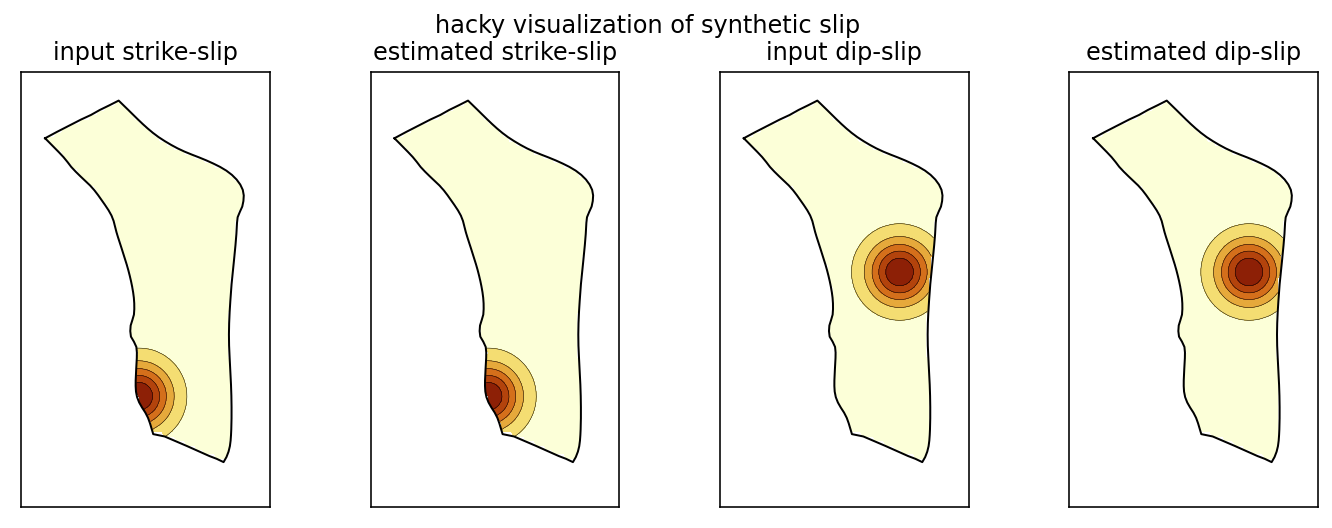

In [8]:
# Define input slip distributions and noisy data

# Cascadia example
sources = addict.Dict()
sources.lon = np.array([236.779, 234.779])
sources.lat = np.array([45.553, 41.553])
sources.magnitude = np.array([1.0, 1.0])
sources.slip_type = ["dip_slip", "strike_slip"]
observation_noise = 0.01

slip_distribution_synthetic, synthetic_displacements = get_synthetic_displacements_test(
    meshes[0], sources, tde_matrix, observation_noise
)

plot_slip_distributions(
    slip_distribution_synthetic,
    slip_distribution_synthetic,
    suptitle_string=f"hacky visualization of synthetic slip",
)


# Direct least squares estimate with no smoothing

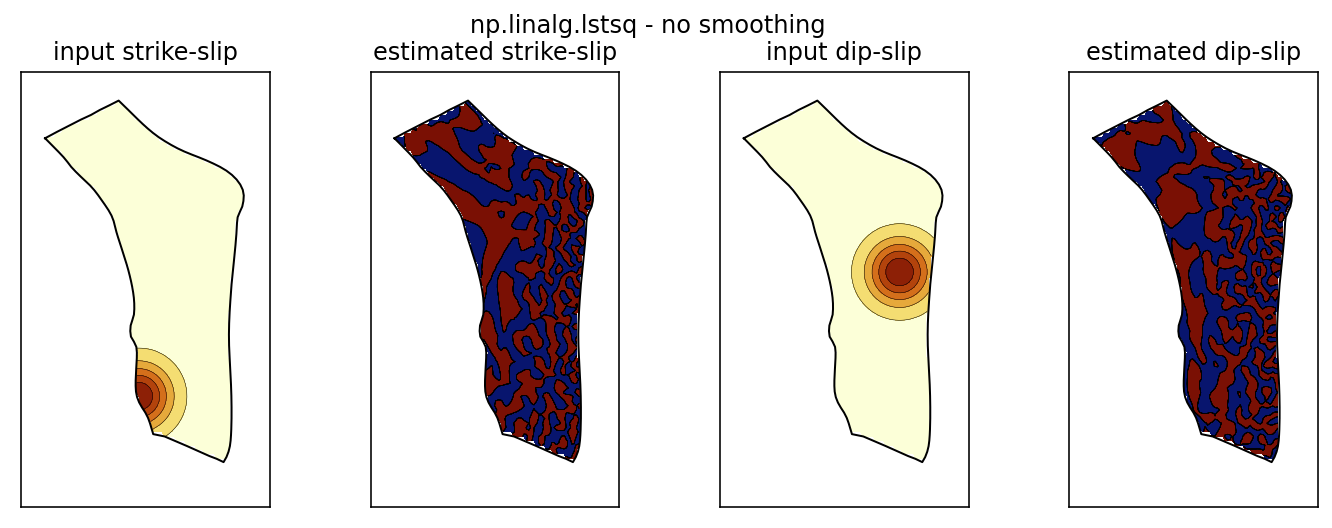

In [9]:
slip_distribution_estimated = np.linalg.lstsq(
    tde_matrix, synthetic_displacements, rcond=None
)

plot_slip_distributions(
    slip_distribution_synthetic,
    slip_distribution_estimated[0],
    suptitle_string="np.linalg.lstsq - no smoothing",
)


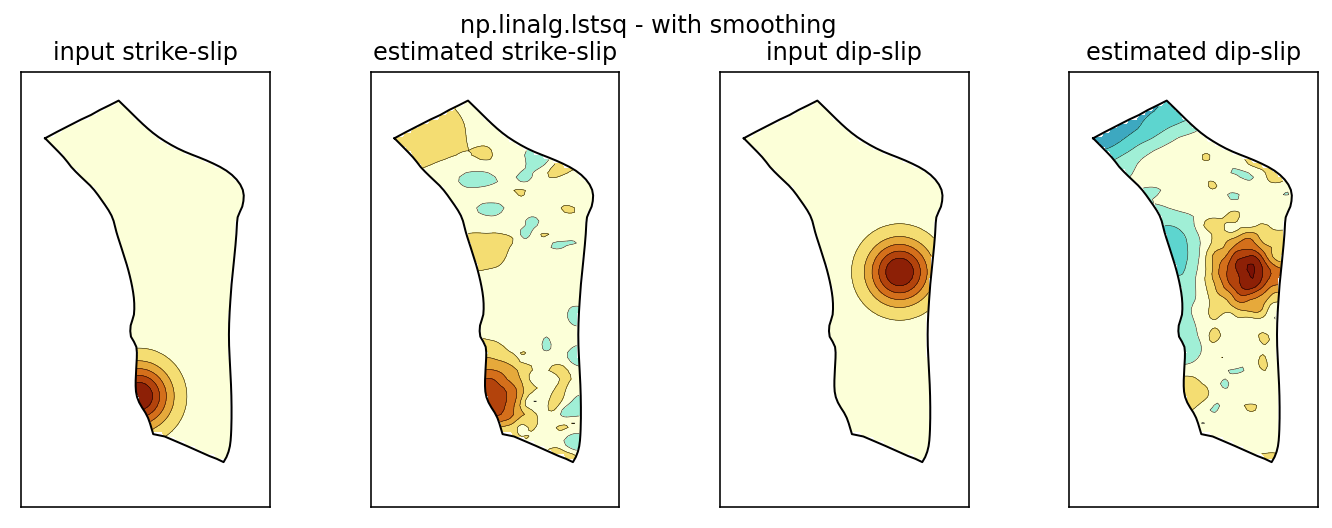

In [10]:
def estimate_slip_smoothed(smoothing_weight, synthetic_displacements):
    smoothing_matrix = operators.smoothing_matrix[0].todense()
    smoothing_matrix = np.delete(
        smoothing_matrix, np.arange(2, smoothing_matrix.shape[0], 3), axis=0
    )
    smoothing_matrix = np.delete(
        smoothing_matrix, np.arange(2, smoothing_matrix.shape[1], 3), axis=1
    )
    tde_matrix_smoothing_augmented = np.vstack(
        (tde_matrix, smoothing_weight * smoothing_matrix)
    )
    synthetic_displacements_smoothing_augmented = np.hstack(
        (synthetic_displacements, np.zeros(tde_matrix.shape[1]))
    )

    # Direct least squares estimate with smoothing
    slip_distribution_estimated = np.linalg.lstsq(
        tde_matrix_smoothing_augmented,
        synthetic_displacements_smoothing_augmented,
        rcond=None,
    )

    slip_distribution_estimated = slip_distribution_estimated[0]

    # Assess goodness of fit to data
    predicted_displacments = tde_matrix @ slip_distribution_estimated
    mae = (
        np.sum(np.abs(predicted_displacments - synthetic_displacements))
        / synthetic_displacements.size
    )
    mse = (
        np.sum((predicted_displacments - synthetic_displacements) ** 2.0)
    ) / synthetic_displacements.size

    return slip_distribution_estimated, mae, mse


# Smoothed least squares
smoothing_weight = 1e7
slip_distribution_estimated, mae, mse = estimate_slip_smoothed(
    smoothing_weight, synthetic_displacements
)

plot_slip_distributions(
    slip_distribution_synthetic,
    slip_distribution_estimated,
    suptitle_string="np.linalg.lstsq - with smoothing",
)


# Reference eigenvalue slip estimate

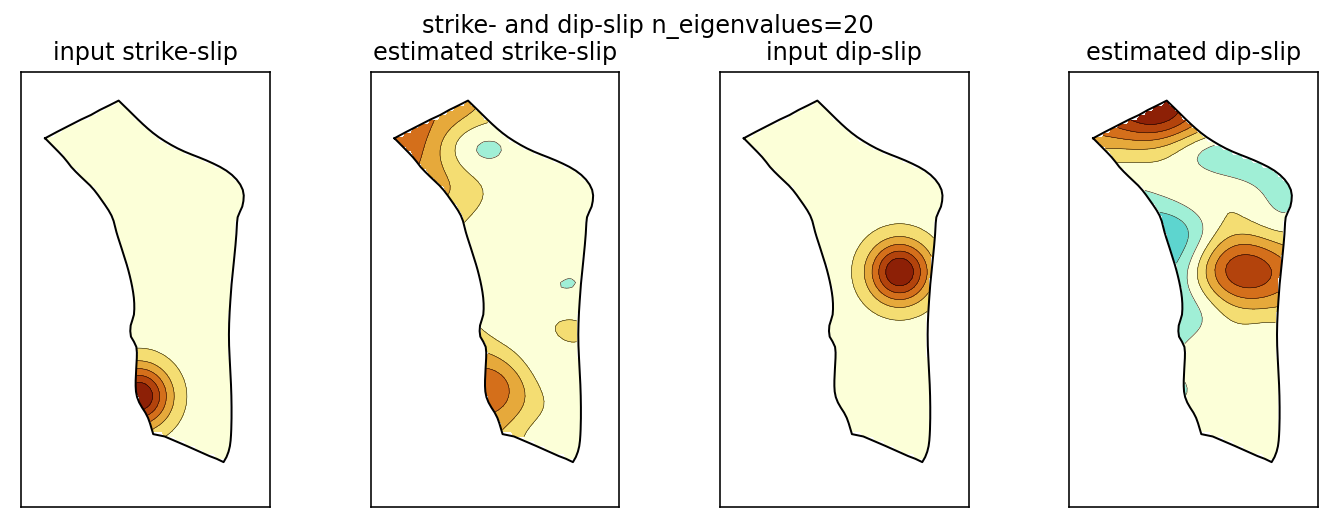

In [11]:
def estimate_slip_eigenvectors(n_eigenvalues, synthetic_displacements):
    # Eigenvalue slip estimate with strike- and dip-slip
    eigenvalues, eigenvectors = get_eigenvalues_and_eigenvectors(
        n_eigenvalues, meshes[0].x_centroid, meshes[0].y_centroid, meshes[0].z_centroid
    )

    # Create modified eigenvector matrix here
    # TODO: clean indexing and rename new eigenvector matrix???
    eigenvectors_two_component = np.zeros(
        (2 * eigenvectors.shape[0], 2 * eigenvectors.shape[1])
    )
    for i in range(n_eigenvalues):
        index_column_1 = 2 * i
        index_column_2 = 2 * i + 1
        eigenvectors_two_component[0::2, index_column_1] = eigenvectors[:, i]
        eigenvectors_two_component[1::2, index_column_2] = eigenvectors[:, i]

    # Solve for eigenvector weights
    eigenvector_weights_estimated = (
        np.linalg.pinv(tde_matrix @ eigenvectors_two_component)
        @ synthetic_displacements
    )

    # Recover slip from eigenvector weights
    slip_distribution_estimated = (
        eigenvectors_two_component @ eigenvector_weights_estimated
    )

    # Assess goodness of fit to data
    predicted_displacments = tde_matrix @ slip_distribution_estimated
    mae = (
        np.sum(np.abs(predicted_displacments - synthetic_displacements))
        / synthetic_displacements.size
    )
    mse = (
        np.sum((predicted_displacments - synthetic_displacements) ** 2.0)
    ) / synthetic_displacements.size

    return slip_distribution_estimated, mae, mse


n_eigenvalues = 20
slip_distribution_estimated_two_component, mae, mse = estimate_slip_eigenvectors(
    n_eigenvalues, synthetic_displacements
)

plot_slip_distributions(
    slip_distribution_synthetic,
    slip_distribution_estimated_two_component,
    suptitle_string=f"strike- and dip-slip {n_eigenvalues=}",
)

# Smoothing weight parameter sweep

In [32]:
if SMOOTHING_SWEEP_EXPERIMENT == True:
    # Loop over number of smoothing values to get residual sensitivity for slip and displacements
    smoothing_sweep = addict.Dict()
    smoothing_sweep.smoothing_weights_array = np.logspace(4, 8, 20)
    smoothing_sweep.mae_displacement_array = np.zeros(
        smoothing_sweep.smoothing_weights_array.size
    )
    smoothing_sweep.mse_displacement_array = np.zeros(
        smoothing_sweep.smoothing_weights_array.size
    )
    slip_list = list()
    smoothing_sweep.mae_slip_array = np.zeros(
        smoothing_sweep.smoothing_weights_array.size
    )
    smoothing_sweep.mse_slip_array = np.zeros(
        smoothing_sweep.smoothing_weights_array.size
    )

    for i in range(smoothing_sweep.smoothing_weights_array.size):
        smoothing_weight = smoothing_sweep.smoothing_weights_array[i]
        print(smoothing_weight)
        slip_distribution_estimated, mae, mse = estimate_slip_smoothed(
            smoothing_weight, synthetic_displacements
        )

        slip_list.append(slip_distribution_estimated)
        smoothing_sweep.mae_displacement_array[i] = mae
        smoothing_sweep.mse_displacement_array[i] = mse
        smoothing_sweep.mae_slip_array[i] = (
            np.sum(np.abs(slip_distribution_synthetic - slip_distribution_estimated))
            / slip_distribution_synthetic.size
        )
        smoothing_sweep.mse_slip_array[i] = (
            np.sum((slip_distribution_synthetic - slip_distribution_estimated) ** 2.0)
            / slip_distribution_synthetic.size
        )
    smoothing_sweep.slip_array = np.array(slip_list)

    # Save sweep information
    np.savez(
        "smoothing_sweep.npz",
        slip_array=smoothing_sweep.slip_array,
        mae_displacement_array=smoothing_sweep.mae_displacement_array,
        mse_displacement_array=smoothing_sweep.mse_displacement_array,
        mae_slip_array=smoothing_sweep.mae_slip_array,
        mse_slip_array=smoothing_sweep.mse_slip_array,
    )


10000.0
16237.76739188721
26366.508987303554
42813.32398719396


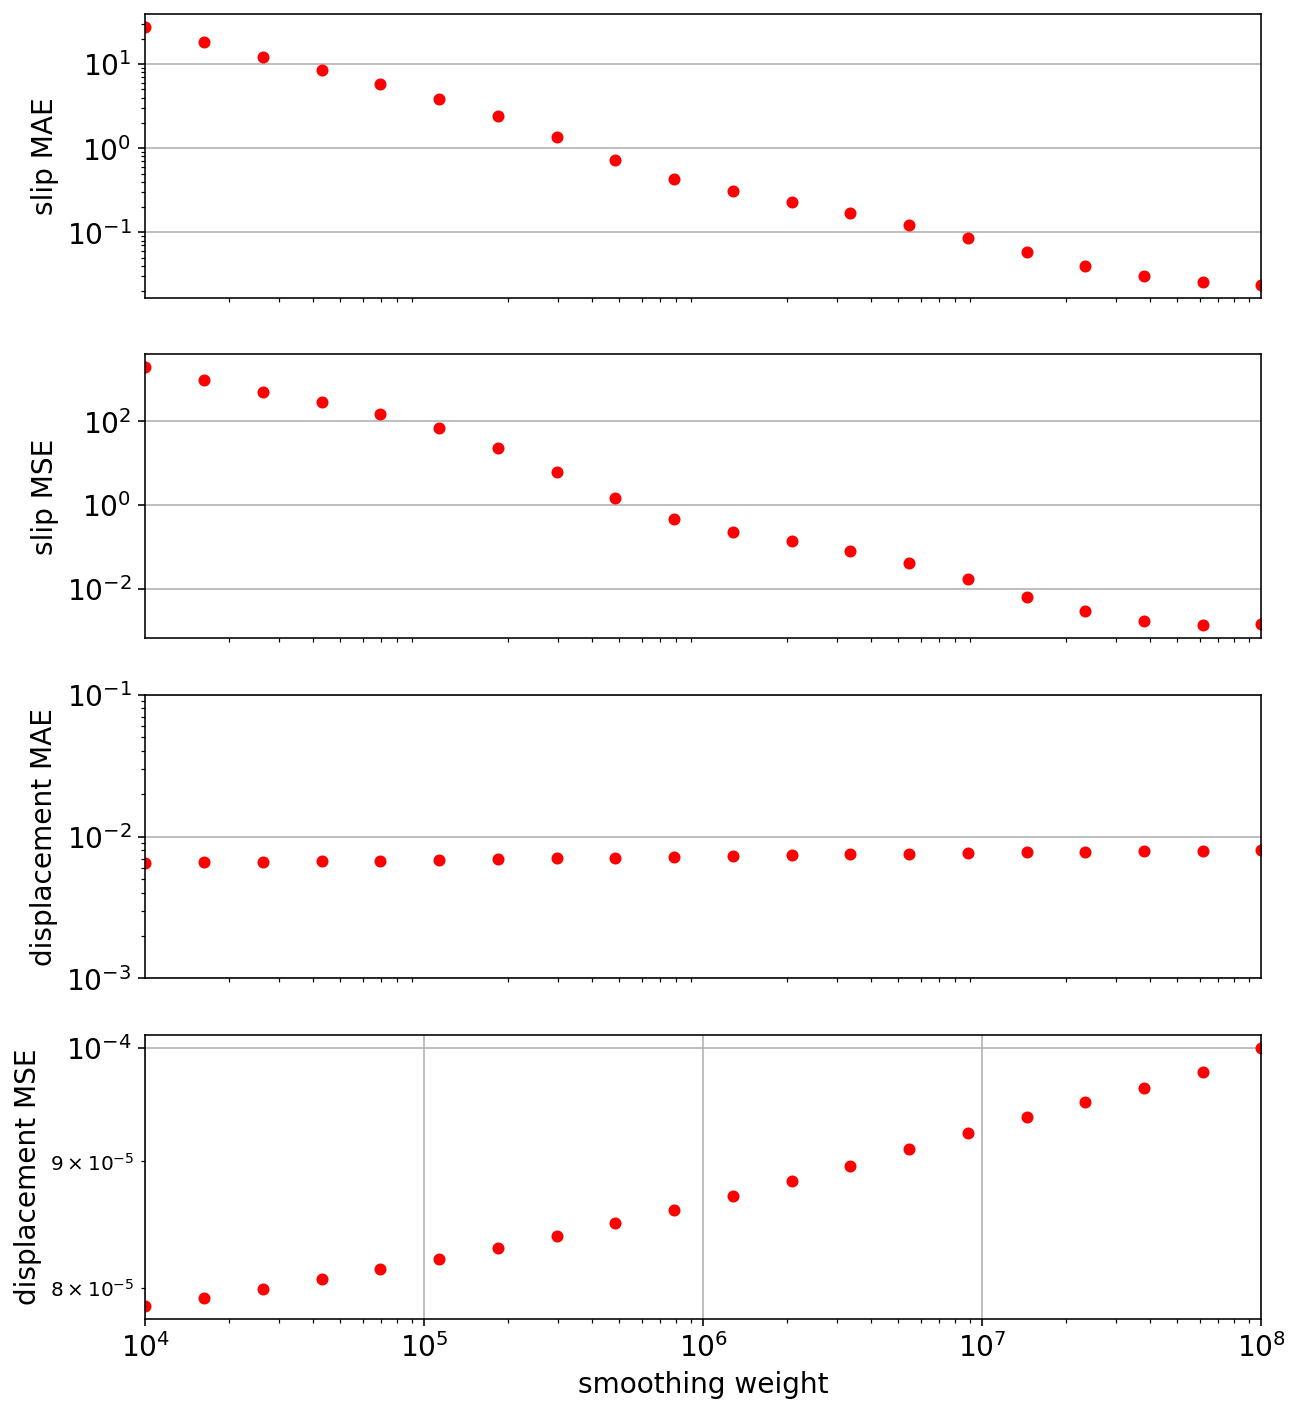

In [13]:
if SMOOTHING_SWEEP_EXPERIMENT == True:
    fontsize = 14
    linewidth = 0.5
    markersize = 10.0

    plt.figure(figsize=(10, 12))
    plt.subplot(4, 1, 1)
    plt.loglog(smoothing_sweep.smoothing_weights_array, smoothing_sweep.mae_slip_array, ".r", linewidth=linewidth, markersize=markersize)
    plt.ylabel("slip MAE", fontsize=fontsize)
    # plt.xticks([0, 100, 200, 300, 400], [])
    plt.tick_params(labelsize=fontsize)
    plt.xlim([np.min(smoothing_sweep.smoothing_weights_array), np.max(smoothing_sweep.smoothing_weights_array)])
    plt.grid(True)

    plt.subplot(4, 1, 2)
    plt.loglog(smoothing_sweep.smoothing_weights_array, smoothing_sweep.mse_slip_array, ".r", linewidth=linewidth, markersize=markersize)
    plt.ylabel("slip MSE", fontsize=fontsize)
    # plt.xticks([0, 100, 200, 300, 400], [])
    plt.tick_params(labelsize=fontsize)
    plt.xlim([np.min(smoothing_sweep.smoothing_weights_array), np.max(smoothing_sweep.smoothing_weights_array)])
    plt.grid(True)

    plt.subplot(4, 1, 3)
    plt.loglog(smoothing_sweep.smoothing_weights_array, smoothing_sweep.mae_displacement_array, ".r", linewidth=linewidth, markersize=markersize)
    plt.ylabel("displacement MAE", fontsize=fontsize)
    # plt.xticks([0, 100, 200, 300, 400], [])
    plt.tick_params(labelsize=fontsize)
    plt.xlim([np.min(smoothing_sweep.smoothing_weights_array), np.max(smoothing_sweep.smoothing_weights_array)])
    plt.ylim([1e-3, 1e-1])
    plt.grid(True)

    plt.subplot(4, 1, 4)
    plt.loglog(smoothing_sweep.smoothing_weights_array, smoothing_sweep.mse_displacement_array, ".r", linewidth=linewidth, markersize=markersize)
    plt.xlabel("smoothing weight", fontsize=fontsize)
    plt.ylabel("displacement MSE", fontsize=fontsize)
    plt.xlim([np.min(smoothing_sweep.smoothing_weights_array), np.max(smoothing_sweep.smoothing_weights_array)])
    plt.grid(True)

    plt.tick_params(labelsize=fontsize)

    # plt.savefig("smoothing_sweep.pdf")
    # plt.savefig("smoothing_sweep.png", dpi=500)
    plt.show()

# Eigenvalue parameter sweep

In [18]:
if EIGENVECTOR_SWEEP_EXPERIMENT == True:
    # Loop over number of eigenvalues to get residual sensitivity for slip and displacements
    eigenvector_sweep = addict.Dict()
    eigenvector_sweep.n_eigenvalues_array = np.arange(1, 421, 20)

    eigenvector_sweep.mae_displacement_array = np.zeros(
        eigenvector_sweep.n_eigenvalues_array.size
    )
    eigenvector_sweep.mse_displacement_array = np.zeros(
        eigenvector_sweep.n_eigenvalues_array.size
    )
    slip_list = list()
    eigenvector_sweep.mae_slip_array = np.zeros(
        eigenvector_sweep.n_eigenvalues_array.size
    )
    eigenvector_sweep.mse_slip_array = np.zeros(
        eigenvector_sweep.n_eigenvalues_array.size
    )

    for i in range(eigenvector_sweep.n_eigenvalues_array.size):
        n_eigenvalues = eigenvector_sweep.n_eigenvalues_array[i]
        print(n_eigenvalues)
        slip_distribution_estimated, mae, mse = estimate_slip_eigenvectors(
            n_eigenvalues, synthetic_displacements
        )
        slip_list.append(slip_distribution_estimated)
        eigenvector_sweep.mae_displacement_array[i] = mae
        eigenvector_sweep.mse_displacement_array[i] = mse
        eigenvector_sweep.mae_slip_array[i] = (
            np.sum(np.abs(slip_distribution_synthetic - slip_distribution_estimated))
            / slip_distribution_synthetic.size
        )
        eigenvector_sweep.mse_slip_array[i] = (
            np.sum((slip_distribution_synthetic - slip_distribution_estimated) ** 2.0)
            / slip_distribution_synthetic.size
        )
    eigenvector_sweep.slip_array = np.array(slip_list)


1
21
41
61
81
101
121
141
161
181
201
221
241
261
281
301
321
341
361
381
401


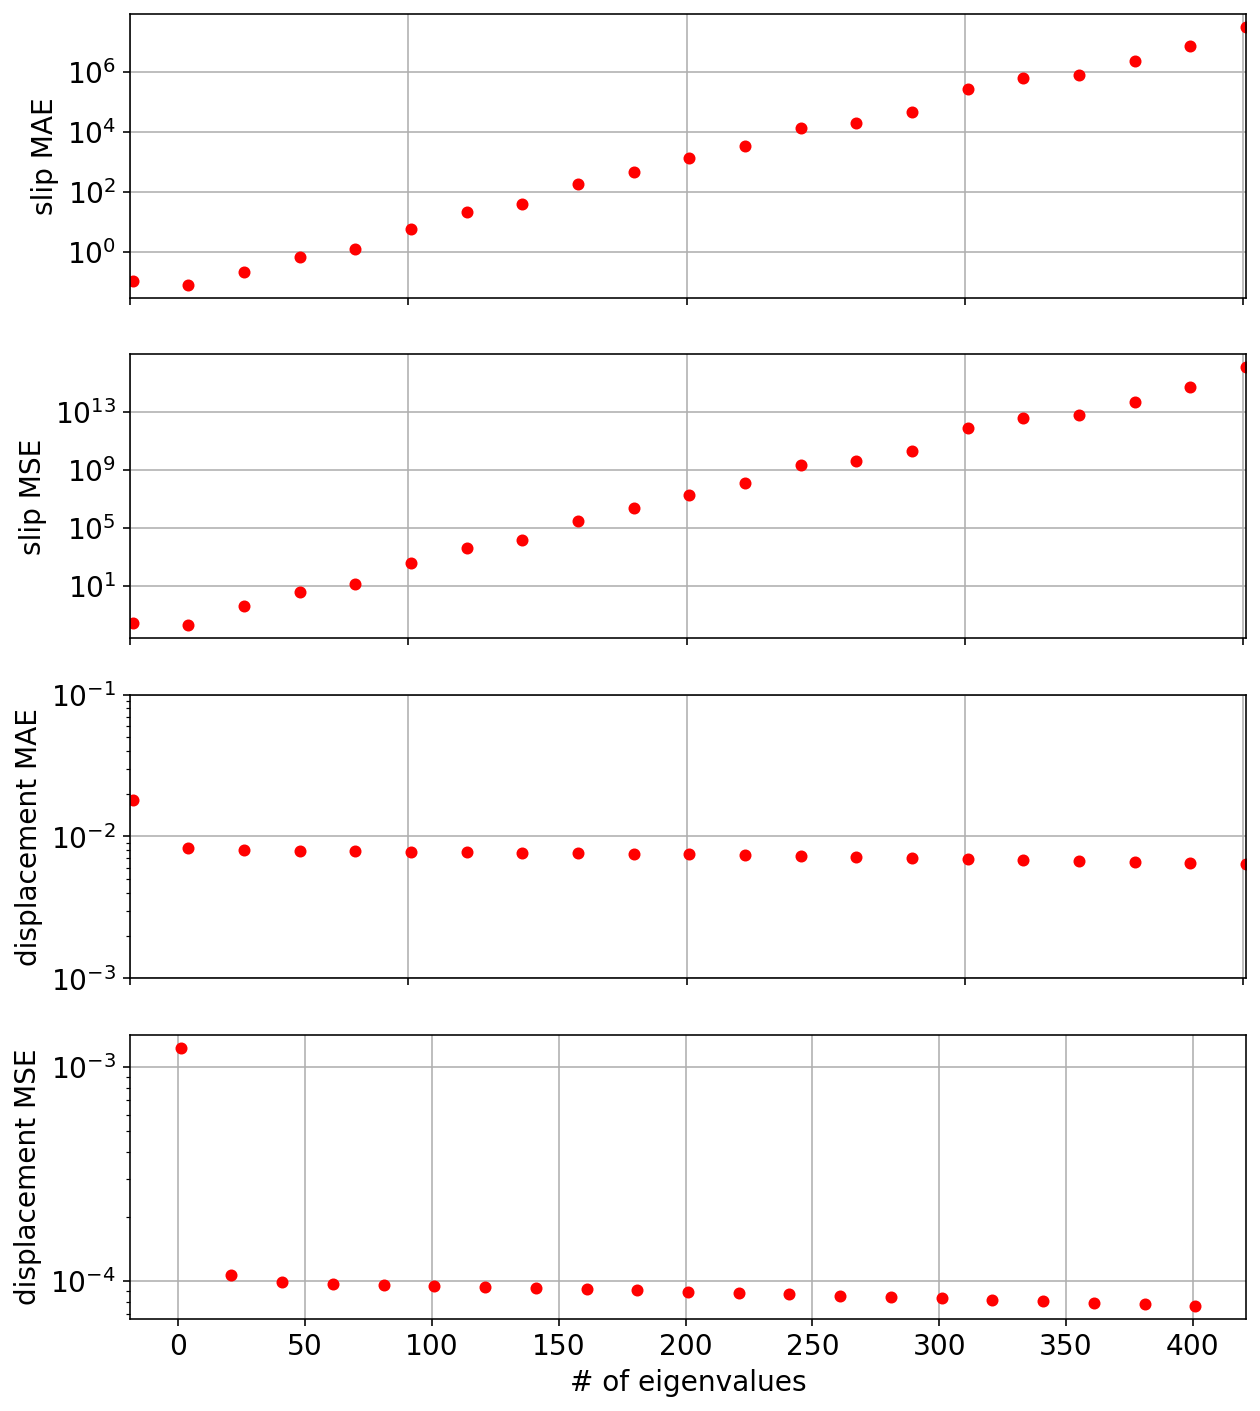

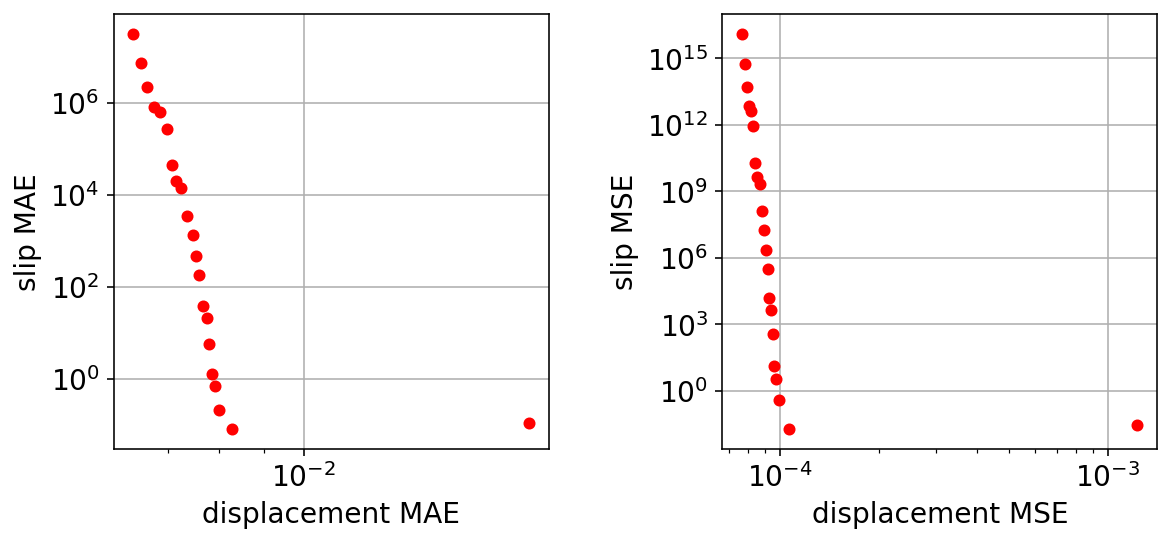

In [31]:
if EIGENVECTOR_SWEEP_EXPERIMENT == True:
    fontsize = 14
    linewidth = 0.5
    markersize = 10.0

    plt.figure(figsize=(10, 12))
    plt.subplot(4, 1, 1)
    plt.semilogy(
        eigenvector_sweep.n_eigenvalues_array,
        eigenvector_sweep.mae_slip_array,
        ".r",
        linewidth=linewidth,
        markersize=markersize,
    )
    plt.ylabel("slip MAE", fontsize=fontsize)
    # plt.xticks([0, 100, 200, 300, 400], [])
    plt.tick_params(labelsize=fontsize)
    plt.xlim([0, np.max(eigenvector_sweep.n_eigenvalues_array)])
    plt.grid(True)

    plt.subplot(4, 1, 2)
    plt.semilogy(
        eigenvector_sweep.n_eigenvalues_array,
        eigenvector_sweep.mse_slip_array,
        ".r",
        linewidth=linewidth,
        markersize=markersize,
    )
    plt.ylabel("slip MSE", fontsize=fontsize)
    # plt.xticks([0, 100, 200, 300, 400], [])
    plt.tick_params(labelsize=fontsize)
    plt.xlim([0, np.max(eigenvector_sweep.n_eigenvalues_array)])
    plt.grid(True)

    plt.subplot(4, 1, 3)
    plt.semilogy(
        eigenvector_sweep.n_eigenvalues_array,
        eigenvector_sweep.mae_displacement_array,
        ".r",
        linewidth=linewidth,
        markersize=markersize,
    )
    plt.ylabel("displacement MAE", fontsize=fontsize)
    # plt.xticks([0, 100, 200, 300, 400], [])
    plt.tick_params(labelsize=fontsize)
    plt.xlim([0, np.max(eigenvector_sweep.n_eigenvalues_array)])
    plt.ylim([1e-3, 1e-1])
    plt.grid(True)

    plt.subplot(4, 1, 4)
    plt.semilogy(
        eigenvector_sweep.n_eigenvalues_array,
        eigenvector_sweep.mse_displacement_array,
        ".r",
        linewidth=linewidth,
        markersize=markersize,
    )
    plt.xlabel("# of eigenvalues", fontsize=fontsize)
    plt.ylabel("displacement MSE", fontsize=fontsize)
    plt.grid(True)
    plt.tick_params(labelsize=fontsize)


    # plt.savefig("eigenvectors_sweep.pdf")
    # plt.savefig("eigenvectors_sweep.png", dpi=500)
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.loglog(
        eigenvector_sweep.mae_displacement_array,
        eigenvector_sweep.mae_slip_array,
        ".r",
        linewidth=linewidth,
        markersize=markersize,
    )
    plt.xlabel("displacement MAE", fontsize=fontsize)
    plt.ylabel("slip MAE", fontsize=fontsize)
    plt.gca().set_aspect(1./plt.gca().get_data_ratio())
    plt.tick_params(labelsize=fontsize)
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.loglog(
        eigenvector_sweep.mse_displacement_array,
        eigenvector_sweep.mse_slip_array,
        ".r",
        linewidth=linewidth,
        markersize=markersize,
    )
    plt.xlabel("displacement MSE", fontsize=fontsize)
    plt.ylabel("slip MSE", fontsize=fontsize)
    plt.gca().set_aspect(1./plt.gca().get_data_ratio())
    plt.tick_params(labelsize=fontsize)
    plt.grid(True)


    plt.show()


In [16]:
n_eigenvalues_array = np.arange(1, 421, 20)
print(n_eigenvalues_array.shape)

(21,)
